<a href="https://colab.research.google.com/github/masdesouza/FDIA-PdM/blob/master/notebooks/regression_LSTM_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Import modules

In [8]:
import keras
import keras.backend as K
from keras.layers.core import Activation
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn import preprocessing

#2. Configuration

In [9]:
# Setting seed for reproducibility
np.random.seed(1234)  
PYTHONHASHSEED = 0

# define path to save model
model_path = '/content/drive/MyDrive/PFC/FDIA-PdM/Trained models/LSTM/regression_model_LSTM.h5'

##2.1 Import dataset

In [10]:
import os
import pickle
from google.colab import drive
from google.colab import files

drive.mount('/content/drive')
os.chdir("/content/drive/MyDrive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#3. Data Ingestion


In [11]:
# read training data - specify the path for the train data
train_df = pd.read_csv('/content/drive/MyDrive/PFC/FDIA-PdM/Datasets/Training/PM_train.txt', sep=" ", header=None)
train_df.drop(train_df.columns[[26, 27]], axis=1, inplace=True)
train_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

train_df = train_df.sort_values(['id','cycle'])

# read test data - specify the path for the test data
test_df = pd.read_csv('/content/drive/MyDrive/PFC/FDIA-PdM/Datasets/Testing/PM_test.txt', sep=" ", header=None)
test_df.drop(test_df.columns[[26, 27]], axis=1, inplace=True)
test_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

# read ground truth data - It contains the information of true remaining cycles for each engine in the testing data.
truth_df = pd.read_csv('/content/drive/MyDrive/PFC/FDIA-PdM/Datasets/Testing/PM_truth.txt', sep=" ", header=None)
truth_df.drop(truth_df.columns[[1]], axis=1, inplace=True)

# 4. Data Preprocessing

# 4.1 Train

In [12]:
# Data Labeling - generate column RUL(Remaining Usefull Life or Time to Failure)
rul = pd.DataFrame(train_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
train_df = train_df.merge(rul, on=['id'], how='left')
train_df['RUL'] = train_df['max'] - train_df['cycle']
train_df.drop('max', axis=1, inplace=True)

# generate label columns for training data
# we will only make use of "label1" for binary classification, 
# while trying to answer the question: is a specific engine going to fail within w1 cycles?
w1 = 30
w0 = 15
train_df['label1'] = np.where(train_df['RUL'] <= w1, 1, 0 )
train_df['label2'] = train_df['label1']
train_df.loc[train_df['RUL'] <= w0, 'label2'] = 2

# MinMax normalization (from 0 to 1)
train_df['cycle_norm'] = train_df['cycle']
cols_normalize = train_df.columns.difference(['id','cycle','RUL','label1','label2'])
min_max_scaler = preprocessing.MinMaxScaler()
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_df[cols_normalize]), 
                             columns=cols_normalize, 
                             index=train_df.index)
join_df = train_df[train_df.columns.difference(cols_normalize)].join(norm_train_df)
train_df = join_df.reindex(columns = train_df.columns)

#train_df.to_csv('../../Dataset/PredictiveTraining.csv', encoding='utf-8',index = None)


## 4.2 Test

In [13]:
# MinMax normalization (from 0 to 1)
test_df['cycle_norm'] = test_df['cycle']
norm_test_df = pd.DataFrame(min_max_scaler.transform(test_df[cols_normalize]), 
                            columns=cols_normalize, 
                            index=test_df.index)
test_join_df = test_df[test_df.columns.difference(cols_normalize)].join(norm_test_df)
test_df = test_join_df.reindex(columns = test_df.columns)
test_df = test_df.reset_index(drop=True)
print(test_df.head())

# We use the ground truth dataset to generate labels for the test data.
# generate column max for test data
rul = pd.DataFrame(test_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
truth_df.columns = ['more']
truth_df['id'] = truth_df.index + 1
truth_df['max'] = rul['max'] + truth_df['more']
truth_df.drop('more', axis=1, inplace=True)

# generate RUL for test data
test_df = test_df.merge(truth_df, on=['id'], how='left')
test_df['RUL'] = test_df['max'] - test_df['cycle']
test_df.drop('max', axis=1, inplace=True)

# generate label columns w0 and w1 for test data
test_df['label1'] = np.where(test_df['RUL'] <= w1, 1, 0 )
test_df['label2'] = test_df['label1']
test_df.loc[test_df['RUL'] <= w0, 'label2'] = 2

#test_df.to_csv('../../Dataset/PredictiveManteinanceTest.csv', encoding='utf-8',index = None)

# pick a large window size of 50 cycles
sequence_length =80

# function to reshape features into (samples, time steps, features) 
def gen_sequence(id_df, seq_length, seq_cols):

    data_matrix = id_df[seq_cols].values
    num_elements = data_matrix.shape[0]

    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_matrix[start:stop, :]

# pick the feature columns
sensor_cols = ['s' + str(i) for i in range(1,22)]
sequence_cols = ['setting1', 'setting2', 'setting3', 'cycle_norm']
sequence_cols.extend(sensor_cols)

# TODO for debug 
# val is a list of 192 - 50 = 142 bi-dimensional array (50 rows x 25 columns)
val=list(gen_sequence(train_df[train_df['id']==1], sequence_length, sequence_cols))
print(len(val))

# generator for the sequences
# transform each id of the train dataset in a sequence
seq_gen = (list(gen_sequence(train_df[train_df['id']==id], sequence_length, sequence_cols)) 
           for id in train_df['id'].unique())

# generate sequences and convert to numpy array
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
print(seq_array.shape)

# function to generate labels
def gen_labels(id_df, seq_length, label):

    data_matrix = id_df[label].values
    num_elements = data_matrix.shape[0]

    return data_matrix[seq_length:num_elements, :]

# generate labels
label_gen = [gen_labels(train_df[train_df['id']==id], sequence_length, ['RUL']) 
             for id in train_df['id'].unique()]

label_array = np.concatenate(label_gen).astype(np.float32)
label_array.shape

   id  cycle  setting1  setting2  ...  s19       s20       s21  cycle_norm
0   1      1  0.632184  0.750000  ...  0.0  0.558140  0.661834     0.00000
1   1      2  0.344828  0.250000  ...  0.0  0.682171  0.686827     0.00277
2   1      3  0.517241  0.583333  ...  0.0  0.728682  0.721348     0.00554
3   1      4  0.741379  0.500000  ...  0.0  0.666667  0.662110     0.00831
4   1      5  0.580460  0.500000  ...  0.0  0.658915  0.716377     0.01108

[5 rows x 27 columns]
112
(12631, 80, 25)


(12631, 1)

# 5. Modeling

In [14]:
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))
def r2_keras(y_true, y_pred):
    """Coefficient of Determination 
    """
    SS_res =  K.sum(K.square( y_true - y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

# 6. EVALUATE ON TEST DATA

seq_array_test_last
(77, 80, 25)
(77, 1)
label_array_test_last
[[ 69.]
 [ 82.]
 [ 91.]
 [ 93.]
 [ 91.]
 [ 95.]
 [ 96.]
 [ 97.]
 [124.]
 [ 95.]
 [ 84.]
 [ 50.]
 [ 28.]
 [ 87.]
 [ 16.]
 [ 57.]
 [113.]
 [ 20.]
 [ 66.]
 [ 97.]
 [ 90.]
 [115.]
 [  8.]
 [ 48.]
 [  7.]
 [ 11.]
 [ 19.]
 [ 21.]
 [ 50.]
 [ 28.]
 [ 18.]
 [ 10.]
 [ 59.]
 [114.]
 [ 47.]
 [ 21.]
 [114.]
 [ 29.]
 [ 26.]
 [ 97.]
 [137.]
 [ 15.]
 [103.]
 [ 37.]
 [114.]
 [100.]
 [ 21.]
 [ 54.]
 [ 72.]
 [ 28.]
 [ 14.]
 [  8.]
 [ 94.]
 [ 50.]
 [131.]
 [126.]
 [113.]
 [ 10.]
 [ 34.]
 [ 63.]
 [ 90.]
 [  8.]
 [  9.]
 [ 58.]
 [ 89.]
 [136.]
 [ 28.]
 [ 38.]
 [ 20.]
 [ 85.]
 [ 55.]
 [128.]
 [137.]
 [ 82.]
 [ 59.]
 [117.]
 [ 20.]]
3/3 - 2s - loss: 1936.0515 - rmse: 33.7404 - r2_keras: -2.5156e-01 - 2s/epoch - 689ms/step

RMSE: 33.74037170410156

R^2: -0.251557320356369
[[0.5862069  0.08333334 0.         ... 0.         0.5736434  0.57594585]
 [0.545977   0.5        0.         ... 0.         0.58914727 0.49392432]
 [0.59195405 0.25       0.       

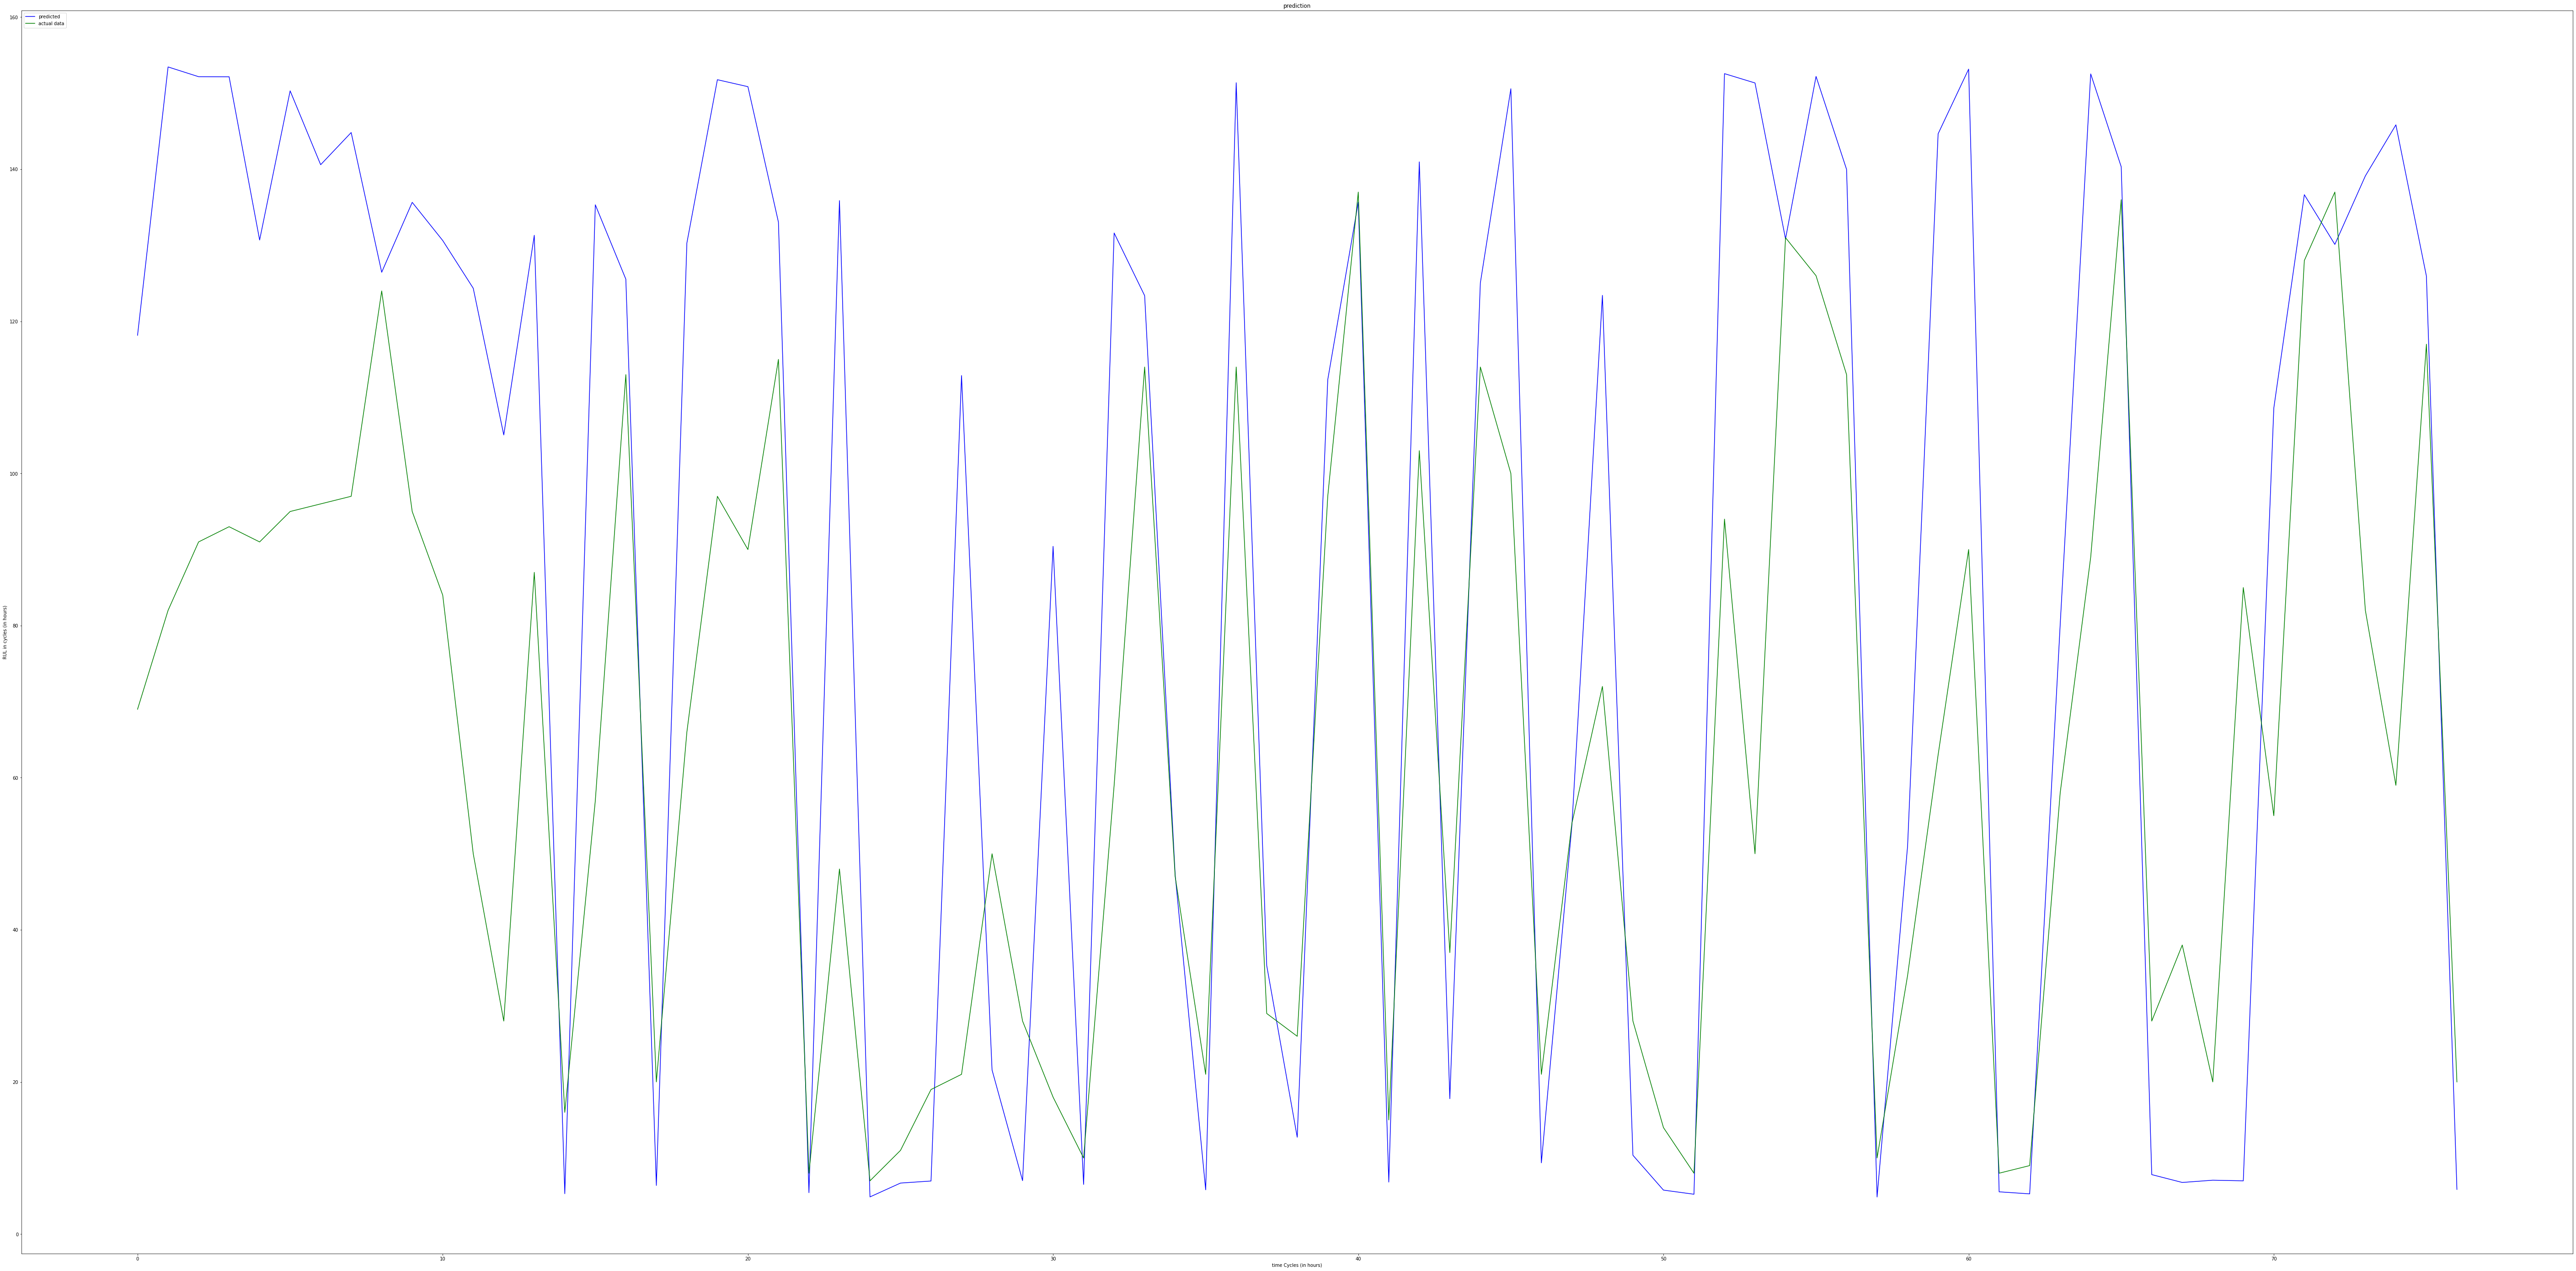

In [15]:
# We pick the last sequence for each id in the test data
seq_array_test_last = [test_df[test_df['id']==id][sequence_cols].values[-sequence_length:] 
                       for id in test_df['id'].unique() if len(test_df[test_df['id']==id]) >= sequence_length]

seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)
print("seq_array_test_last")
#print(seq_array_test_last)
print(seq_array_test_last.shape)

# Similarly, we pick the labels
#print("y_mask")
y_mask = [len(test_df[test_df['id']==id]) >= sequence_length for id in test_df['id'].unique()]
label_array_test_last = test_df.groupby('id')['RUL'].nth(-1)[y_mask].values
label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0],1).astype(np.float32)
print(label_array_test_last.shape)
print("label_array_test_last")
print(label_array_test_last)

# if best iteration's model was saved then load and use it
if os.path.isfile(model_path):
    estimator = load_model(model_path,custom_objects={'r2_keras': r2_keras, 'rmse': rmse})

    # test metrics
    scores_test = estimator.evaluate(seq_array_test_last, label_array_test_last, verbose=2)
    print('\nRMSE: {}'.format(scores_test[1]))
    print('\nR^2: {}'.format(scores_test[2]))

    y_pred_test = estimator.predict(seq_array_test_last)

    print(seq_array_test_last[0])

    y_true_test = label_array_test_last
    print("Prediction")
    print(y_pred_test);
    print("Truth")
    print(y_true_test);


    # Plot in blue color the predicted data and in green color the
    # actual data to verify visually the accuracy of the model.
    fig_verify = plt.figure(figsize=(100, 50))
    plt.plot(y_pred_test, color="blue")
    plt.plot(y_true_test, color="green")
    plt.title('prediction')
    plt.ylabel('RUL in cycles (in hours)')
    plt.xlabel('time Cycles (in hours)')
    plt.legend(['predicted', 'actual data'], loc='upper left')
    plt.show()
    fig_verify.savefig("/content/drive/MyDrive/PFC/FDIA-PdM/Output/model_regression_verify_LSTM_test.png")